In [1]:
import torch
import os 
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn, optim 
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from matplotlib import rc

In [2]:
RANDOM_SEED = 42
print(np.random.seed(RANDOM_SEED))
print(torch.manual_seed(RANDOM_SEED))

None


In [3]:
data = pd.read_csv("./data/time_series_19-covid-Confirmed_archived_0325.csv")
data.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,82,114,147,177,212,272,322,411,599,599.0
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,773,839,825,878,889,924,963,1007,1086,1086.0
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,212,226,243,266,313,345,385,432,455,455.0
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,2,2.0
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,238,428,566,673,790,900,1030,1183,1306,1306.0


In [4]:
data = data.iloc[:, 4:]
data.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20
0,2,3,5,7,8,8,14,14,14,19,...,82,114,147,177,212,272,322,411,599,599.0
1,2,1,2,2,4,4,7,7,11,15,...,773,839,825,878,889,924,963,1007,1086,1086.0
2,0,1,3,3,4,5,7,7,10,13,...,212,226,243,266,313,345,385,432,455,455.0
3,0,0,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,2,2.0
4,0,0,0,3,4,4,4,7,8,8,...,238,428,566,673,790,900,1030,1183,1306,1306.0


In [5]:
data.isnull().sum()

1/22/20      0
1/23/20      0
1/24/20      0
1/25/20      0
1/26/20      0
          ... 
3/19/20      0
3/20/20      0
3/21/20      0
3/22/20      0
3/23/20    192
Length: 62, dtype: int64

In [6]:
daily_cases = data.sum(axis = 0)
daily_cases.head()

1/22/20     555.0
1/23/20     653.0
1/24/20     941.0
1/25/20    1434.0
1/26/20    2118.0
dtype: float64

In [7]:
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

2020-01-22     555.0
2020-01-23     653.0
2020-01-24     941.0
2020-01-25    1434.0
2020-01-26    2118.0
dtype: float64

Text(0.5, 1.0, 'Cumulative Daily Cases')

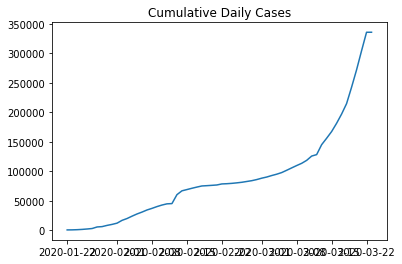

In [8]:
plt.plot(daily_cases)
plt.title("Cumulative Daily Cases")

In [9]:
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()

2020-01-22    555
2020-01-23     98
2020-01-24    288
2020-01-25    493
2020-01-26    684
dtype: int64

Text(0.5, 1.0, 'Daily Cases')

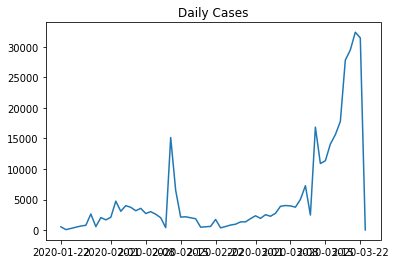

In [10]:
plt.plot(daily_cases)
plt.title("Daily Cases")

In [11]:
daily_cases.shape

(62,)

#### Preprocessing

In [12]:
test_data_size = 14
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
print(train_data.shape, test_data.shape)

(48,) (14,)


In [13]:
scaler= MinMaxScaler()
scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))
test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [14]:
def sliding_windows(data, seq_length):
    xs = []
    ys = []
    
    for i in range(len(data)- seq_length - 1):
        x = data[i: (i + seq_length)]
        y = data[ i + seq_length]
        xs.append(x)
        ys.append(y)
        
    return np.array(xs), np.array(ys)

In [15]:
seq_length = 5

X_train, y_train = sliding_windows(train_data, seq_length)
X_test, y_test = sliding_windows(test_data, seq_length)

In [16]:
print(X_train.shape , y_train.shape)

(42, 5, 1) (42, 1)


In [17]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

#### Building a Model 

In [18]:
class CoronaVirusPredictor(nn.Module):
    def __init__(self,input_dim, hidden_dim, seq_len, num_layers=2):
            super(CoronaVirusPredictor, self).__init__()
            self.input_dim = input_dim
            self.hidden_dim = hidden_dim
            self.seq_len = seq_len
            self.num_layers = num_layers
           
            self.lstm = nn.LSTM(
              input_size = input_dim,
              hidden_size = hidden_dim,
              num_layers = num_layers,
              dropout=0.5
            )

            self.linear= nn.Linear(in_features = hidden_dim, out_features=1)

    def  reset_hidden_state(self):
        
            self.hidden = (
                torch.zeros(self.num_layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.num_layers, self.seq_len, self.hidden_dim)
             )

    def forward(self, input):
        
            lstm_out, self.hidden = self.lstm(
                    input.view(len(input), self.seq_len, -1),
                    self.hidden 
                    )
            y_pred =self.linear(
                    lstm_out.view(self.seq_len, len(input), self.hidden_dim)[-1]
                )
            return y_pred

In [51]:
from torch.optim import Adam

def train_model(model, train_data, train_labels, test_data=None,  test_labels=None):
     
        loss_fn = nn.MSELoss(reduction= 'sum')
        
        optimizer = Adam(model.parameters(), lr = 1e-3)
       
        num_epochs = 60
        train_hist = np.zeros(num_epochs)
        test_hist = np.zeros(num_epochs)

        for t in range(num_epochs):
           
            model.reset_hidden_state()
            y_pred = model(X_train)
            loss = loss_fn(y_pred.float(), y_train)
            
            if test_data is not None:
                with torch.no_grad():
                    y_test_pred = model(X_test)
                    test_loss = loss_fn(y_test_pred.float(), y_test)
                  
                test_hist[t] = test_loss.item()
      
                if t % 10 == 0:
                        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
                elif t % 10 == 0:
                        print(f'Epoch {t} train loss: {loss.item()}')
                  
                  
                train_hist[t] = loss.item()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
          
        return model.eval(), train_hist, test_hist
        
            

In [52]:
model = CoronaVirusPredictor (1, 512, seq_len = seq_length , num_layers=2)
model, train_hist, test_hist = train_model(model, X_train, y_train, X_test,  y_test)

Epoch 0 train loss: 2.0717527866363525 test loss: 19.939144134521484
Epoch 10 train loss: 1.07797372341156 test loss: 16.991018295288086
Epoch 20 train loss: 1.0342861413955688 test loss: 16.58531379699707
Epoch 30 train loss: 1.037254810333252 test loss: 16.53104019165039
Epoch 40 train loss: 1.037719488143921 test loss: 16.79714584350586
Epoch 50 train loss: 1.0536339282989502 test loss: 16.825733184814453


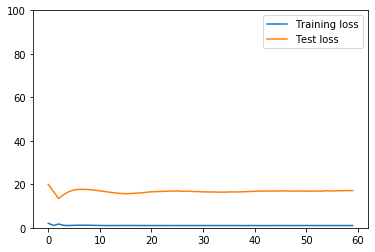

In [53]:
plt.plot(train_hist, label = 'Training loss')
plt.plot(test_hist, label = 'Test loss')
plt.ylim((0,100))
plt.legend()
plt.show()

In [63]:
with torch.no_grad():
      
    test_seq = X_test[:1]
    preds = []
    for _ in range(len(X_test)):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [64]:
true_cases = scaler.inverse_transform(
      np.expand_dims(y_test.flatten().numpy(), axis=0)).flatten()

predicted_cases = scaler.inverse_transform(
      np.expand_dims(preds, axis=0)).flatten()

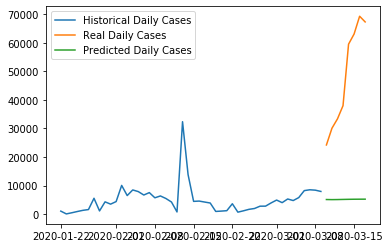

In [65]:
plt.plot(
  daily_cases.index[:len(train_data)],
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Cases'
)
plt.legend();

#### Use all data for training

In [72]:
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))
all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))
all_data.shape

(62, 1)

In [73]:
X_all, y_all = sliding_windows(all_data, seq_length)
X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()
print(X_all.shape, y_all.shape)

torch.Size([56, 5, 1]) torch.Size([56, 1])


In [74]:
model1 = CoronaVirusPredictor( 1, 512, seq_len =seq_length, num_layers=2)
model1, train_hist, test_hist = train_model(model, X_all, y_all)

In [78]:
DAYS_TO_PREDICT = 8
with torch.no_grad():
        test_seq = X_all[:1]
        preds = []
        for _ in range(len(X_test)):
            y_test_pred = model1(test_seq)
            pred = torch.flatten(y_test_pred).item()
            preds.append(pred)

            new_seq = test_seq.numpy().flatten()
            new_seq = np.append(new_seq, [pred])
            new_seq = new_seq[1:]
            test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [79]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()
print(predicted_cases.shape)

(8,)


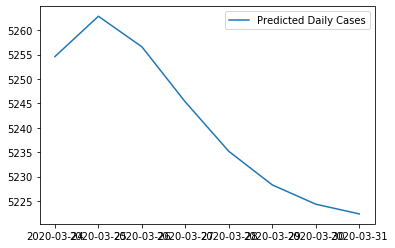

In [80]:
daily_cases.index[-1]
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)
predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();


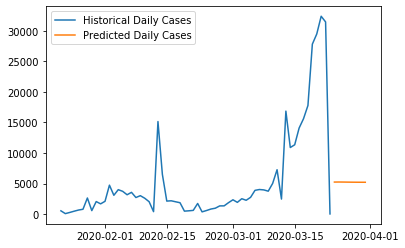

In [81]:
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();